In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pickle
import json
import pandas as pd
from datetime import datetime
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
from nilearn.reporting import make_glm_report
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
sys.path.append('..')
from utils.data import Subject, load_participant_list, create_dummy_regressors
from utils.analysis import compute_parametric_modulator

In [3]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

sub_ids = load_participant_list(base_dir)

In [27]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '14', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

In [28]:
model_params = {
    'model_name': 'labmeeting',
    'tr': 2.33384,
    'hrf_model': 'spm',
    'noise_model': 'ar1',
    'smoothing_fwhm': 5,
    'high_pass': 0.01,
    'motion_type': 'basic',
    'fd_thresh': 0.5,
    'std_dvars_thresh': 2.5,
    'scrub': 'dummies',
    'modulators': 'both',
    'exclude_stimuli': False,
    'include_physio': True,
    'brain_mask': True,
    'modulator_normalization': None
}

run = 'test'

In [29]:
# Parameters
model_name = model_params["model_name"]
tr = model_params["tr"]
hrf_model = model_params["hrf_model"]
noise_model = model_params["noise_model"]
smoothing_fwhm = model_params["smoothing_fwhm"]
high_pass = model_params["high_pass"]
include_physio = model_params["include_physio"]
brain_mask = model_params["brain_mask"]
modulator_normalization = model_params["modulator_normalization"]
modulators = model_params["modulators"]
exclude_stimuli = model_params["exclude_stimuli"]
motion_type = model_params["motion_type"]
fd_thresh = model_params["fd_thresh"]
std_dvars_thresh = model_params["std_dvars_thresh"]
scrub = model_params["scrub"]

In [30]:
# Load confounds
confounds, sample_mask = subject.load_confounds(run, motion_type=motion_type,
                                                fd_thresh=fd_thresh, std_dvars_thresh=std_dvars_thresh,
                                                scrub=(0 if scrub == 'dummies' else scrub))
if include_physio:
    physio_regressors = subject.load_physio_regressors(run)
    confounds = confounds.join(physio_regressors)

In [31]:
if scrub == 'dummies':
    dummies = create_dummy_regressors(sample_mask, len(confounds))
    confounds = pd.concat([confounds, dummies], axis=1)

In [32]:
# Load fMRI volume
img_path = subject.img.get(run)
fmri_img = load_img(img_path)

In [33]:
if brain_mask:
    brain_mask_path = subject.brain_mask.get(run)
    brain_mask = load_img(brain_mask_path)
else:
    brain_mask = None

n = fmri_img.shape[-1]
frametimes = np.linspace(tr / 2., (n - .5) * tr, n)

In [34]:
if modulators == 'both':
    columns_event = {'first_stim_value_rl':'first_stim_presentation',
                    'first_stim_value_ck':'first_stim_presentation',
                    'first_stim':'first_stim_presentation'}
    # Load events
    events = getattr(subject, run).extend_events_df(columns_event)
elif modulators == 'none':
    events = getattr(subject, run).events
else:
    raise NotImplementedError("Modulator type not implemented")

In [35]:
if exclude_stimuli:
    events['trial_type'] = events.apply(
        lambda row: f"{row['trial_type']}_{'exclude' if int(row['first_stim']) in (1, 8) else 'include'}"
        if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
        axis=1
    ) 

In [36]:
events_p = events.copy()
events_p.loc[events_p['trial_type'] != 'iti', 'duration'] = 0

In [37]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")
# Create design matrix
design_matrix = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

In [38]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")
# Create design matrix
design_matrix_p = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events_p,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

In [39]:
if modulators == 'both':
    # RL Parametric modulation
    parametric_modulator_column = 'first_stim_value_rl'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix.insert(1, parametric_modulator_column, reg_value)

    # CK Parametric modulation
    parametric_modulator_column = 'first_stim_value_ck'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix.insert(2, parametric_modulator_column, reg_value)

In [40]:
if modulators == 'both':
    # RL Parametric modulation
    parametric_modulator_column = 'first_stim_value_rl'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix_p.insert(1, parametric_modulator_column, reg_value)

    # CK Parametric modulation
    parametric_modulator_column = 'first_stim_value_ck'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix_p.insert(2, parametric_modulator_column, reg_value)

In [41]:
design_matrix.columns

Index(['first_stim_presentation', 'first_stim_value_rl', 'first_stim_value_ck',
       'iti', 'non_response_feedback', 'purple_frame', 'response',
       'second_stim_presentation', 'csf', 'rot_x', 'rot_y', 'rot_z', 'trans_x',
       'trans_y', 'trans_z', 'white_matter', 'cosine00', 'cosine01',
       'cosine02', 'cosine03', 'cosine04', 'physio1', 'physio2', 'physio3',
       'physio4', 'physio5', 'physio6', 'physio7', 'physio8', 'physio9',
       'physio10', 'physio11', 'physio12', 'physio13', 'physio14', 'physio15',
       'physio16', 'physio17', 'physio18', 'scrub_vol_167', 'scrub_vol_168',
       'scrub_vol_169', 'scrub_vol_460', 'scrub_vol_476', 'scrub_vol_477',
       'scrub_vol_521', 'scrub_vol_586', 'scrub_vol_588', 'constant'],
      dtype='object')

In [42]:
# Select the first 8 columns and the first 100 rows
cols2plot = ['first_stim_presentation', 'first_stim_value_rl', 'first_stim_value_ck']
subset_design_matrix = design_matrix.iloc[:50,:]
subset_design_matrix = subset_design_matrix[cols2plot]

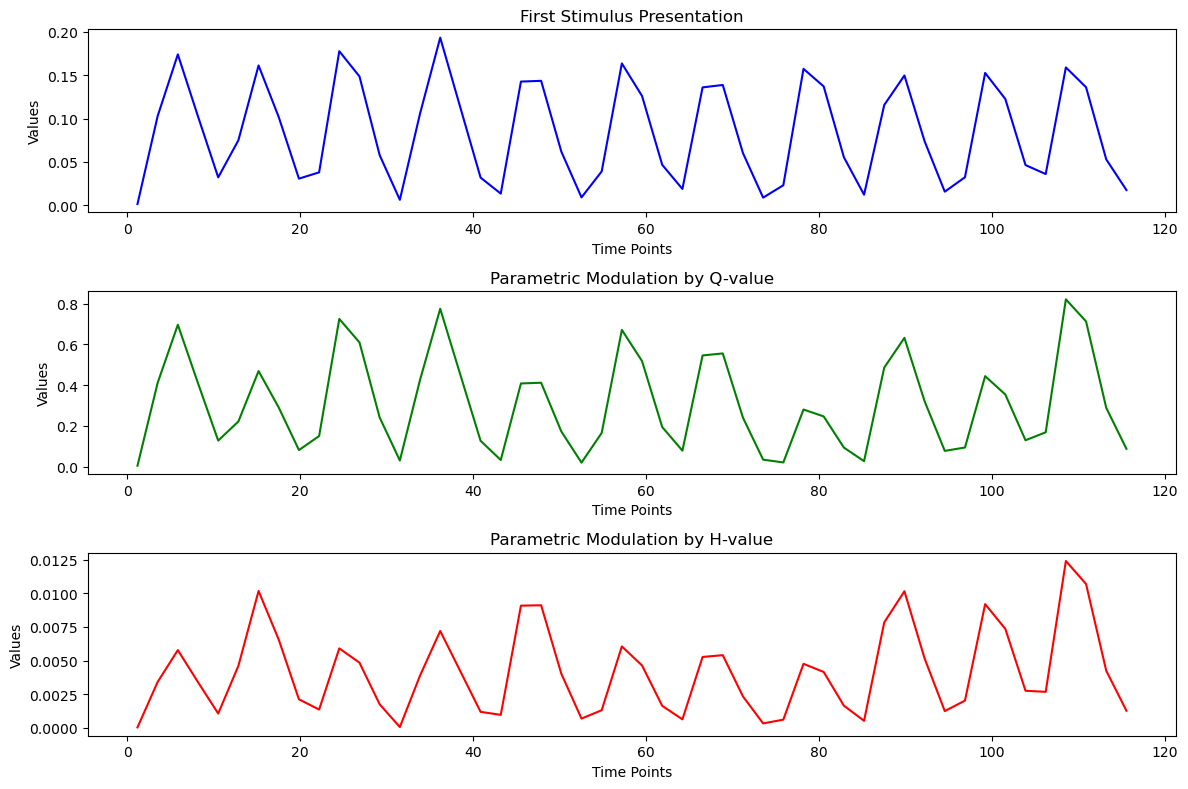

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

titles = ['First Stimulus Presentation',
          'Parametric Modulation by Q-value',
          'Parametric Modulation by H-value']

colors = ['blue', 'green', 'red']

for i, col in enumerate(cols2plot):
    subset_design_matrix[col].plot(ax=axes[i], color=colors[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Time Points')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()
